# Understanding missing data in Python

Once your data is safely localized, one of the first and most important things that you have to do at the beginning of any data analytics project is taking "a lay of the land" with your data. Data is fundamentally messy: full of oddities and noise and incomplete entries.

Getting a handle on this weirdness is an essential first step to getting anything actually done with it.

Thus one of the core skills of data analytics is understanding how your missing data is codistributed. In this tutorial we will tackle just that.

## Numpy

[Numpy](http://www.numpy.org/) is the linear algebra and vectorized mathematical operation toolkit which underpins all of the mathematically intensive code in the Python scientific programming stack. The data handling techniques it incorporates for missing data inform the way libraries farther up the stack (`scipy`, `pandas`, `matplotlib`, etc.) work.

I will touch on that briefly here. At the heart of the matter is the need to distinguish between two types of missingness:

* **Unknown but existing data**: This is data that we know exists, but which, due to sparse or incomplete sampling, we do not actually know the value of. There is some value there, however, and it would be useful to try to apply some sort of missing data interpolation technique in order to discover it.

   For example, in 2013 *The New York Times* published [a survey of income mobility in the United States](http://www.nytimes.com/2013/07/22/business/in-climbing-income-ladder-location-matters.html). As happens often in datasets which drill this deep (to a county level), there were several counties for which the newspaper could not trace data. Yet it would be possible, and easy, if it was truly necessary to do so, to interpolate reasonable values for these counties based on data from the surrounding ones, for instance, or based on data from other counties with similar demographic profiles. This is, fundamentally speaking, data that *can* be filled by some means.

<!-- ![Map of the US by Income Mobility](location_matters.png "Map of the US by Income Mobility") -->
 
  
* **Data that doesn't exist**: data that does not exist at all, in any shape or form.

  For example, it would make no sense to ask what the average household income is of residents of an industrial park or other such location where no people actually live. It would not *really* make sense to use 0 as a [sentinal value](https://en.wikipedia.org/wiki/Sentinel_value) in this case, either, because the existance of such a number implies in the first place the existance of people for whom an average can be taken&mdash;otherwise in trying to compute an average you are making a [divide by zero error](https://en.wikipedia.org/wiki/Division_by_zero)! This is, fundamentally speaking, data that *cannot* be filled by any means.


This is an important distinction to keep in mind, and implementing it in some standard way significantly complicates the picture. It means that to ask the question "is this data entry filled?" one must actually consider three possible answers: "Yes", "No, but it can be", and "No, and it cannot be".

There seem to be two ways of handling this distinction:

* **bitpatterns**: Embed sentinal values into the array itself. For instance for integer data one might take `0.0` to mean unknown but existant data. This requires no overhead but can be confusing and oftentimes robs you of values that you might otherwise want to use (like `0.0`).
* **masks**: Use a seperate boolean array to "mask" the data whenever missing data needs to be represented. This requires making a second array and knowing when to apply it to the dataset, but is more robust.

Masks are defined by the extensive `numpy.ma` module, which is how e.g. `matplotlib` and `scikit.timeseries` handles the problem. But there is still no performant native bitpattern `NA` type exists whatsoever! As we will see this is a huge problem for libraries that are meant to be able to efficiently handle large datasets.

To read more on the conscientious backstory of missing data representation in `numpy` see the [NA-overview summary](http://www.numpy.org/NA-overview.html). To learn more about masked arrays see [its documentation](http://docs.scipy.org/doc/numpy/reference/maskedarray.html).

## Pandas

[Pandas](http://pandas.pydata.org/) serves as the unlying tabular bed which underpins almost all data representation in the scientific programming stack. It abstracts the problems `numpy` presents and provides actual tools for dealing with the core issue: data missingness.

**Pandas does not use the `numpy.ma` mask**. As mentioned above, masks are simply not performant above for the purposes of a library that is expected to be able to handle literally millions of entries entirely in-memory, as `pandas` does.

Pandas instead defines and uses its own null value sentinels, particularly `NaN` (`np.nan`) for null numbers and `NaT` (a psuedo-native handled under-the-hood). The `pandas` documentation [has an entire page devoted to missing value definition and interpolation](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). That is not my focus. Instead let's take a look at what tools `pandas` provides for the slightly earlier step of 

In [15]:
import numpy as np

In [23]:
dat.sample(250).values.view()

array([['09/22/2012', '21:30', nan, ..., nan, nan, nan],
       ['11/25/2012', '16:10', 'QUEENS', ..., nan, nan, nan],
       ['02/09/2016', '10:30', 'QUEENS', ..., nan, nan, nan],
       ..., 
       ['09/28/2012', '1:10', nan, ..., nan, nan, nan],
       ['11/15/2013', '8:55', nan, ..., nan, nan, nan],
       ['01/09/2013', '21:40', 'BRONX', ..., nan, nan, nan]], dtype=object)

## Pandas

In [13]:
%matplotlib inline

import missingno as msno
import requests
import os
import pandas as pd

def download_file(url, filename):
    """
    Helper method handling downloading large files from `url` to `filename`. Returns a pointer to `filename`.
    """
    r = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    return filename


if not os.path.isfile("NYPD Motor Vehicle Collisions.csv"):
    dat = download_file("https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD",
                        "NYPD Motor Vehicle Collisions.csv")
dat = pd.read_csv("NYPD Motor Vehicle Collisions.csv", index_col=23)

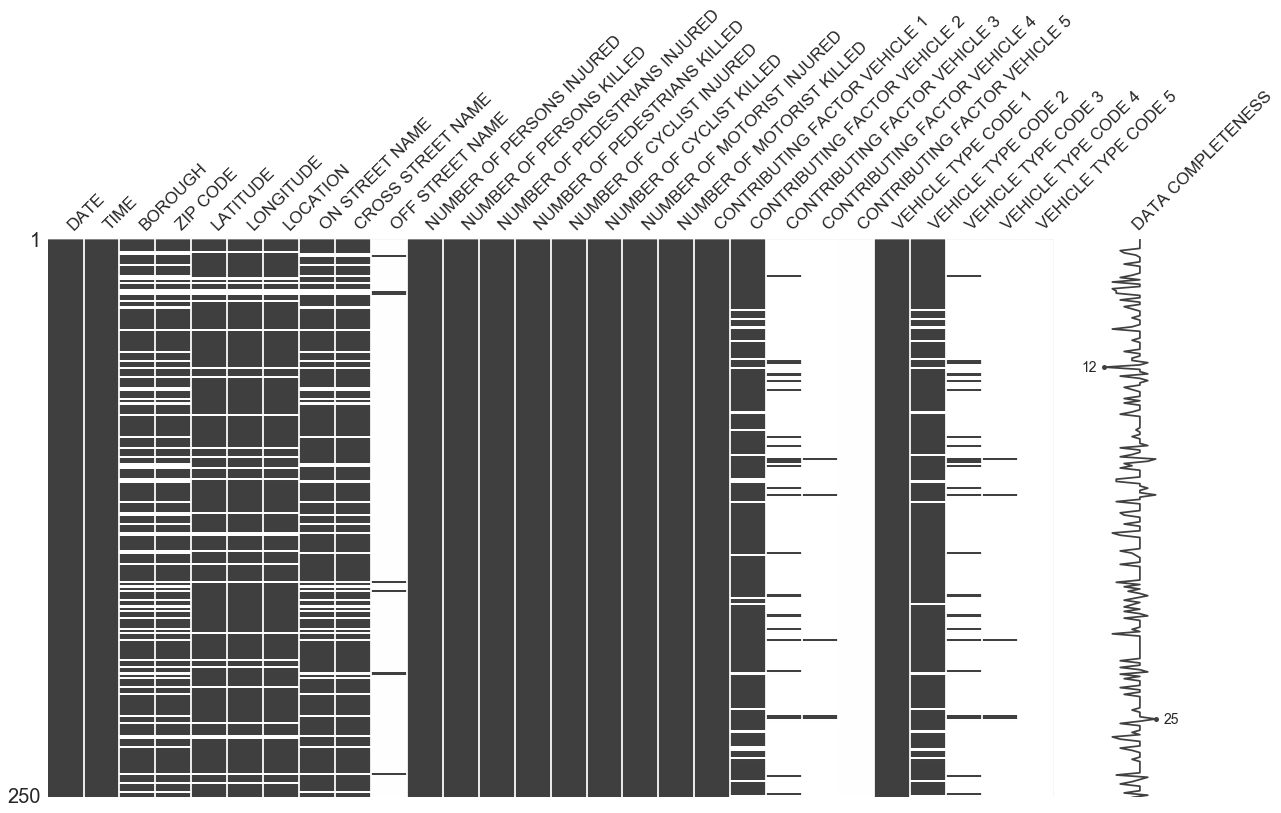

In [14]:
msno.matrix(dat.sample(250))